In [0]:
import sys
sys.path.append("/content/Tools/")

In [26]:
!pip install Boruta

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from Tools.data_processing import FeatureSelector

In [0]:
n_features = 100
n_informative = 10
n_redundant = 50
n_repeated = 25
n_useless = 15

In [0]:
# Create Labels
informative_labels = [f'Informative {ii}' for ii in range(1, n_informative + 1)]
redundant_labels = [f'Redundant {ii}' for ii in range(n_informative + 1, n_informative + n_redundant + 1)]
repeated_labels = [f'Repeated {ii}' for ii in range(n_informative + n_redundant+ 1, n_informative + n_redundant + n_repeated + 1)]
useless_labels = [f'Useless {ii}' for ii in range(n_informative + n_redundant + n_repeated + 1, n_features + 1)]
labels = informative_labels + redundant_labels + repeated_labels + useless_labels

In [0]:
# Get data
X_madelon, y_madelon = make_classification(n_samples = 1000, n_features = n_features,
                           n_informative = n_informative,
                           n_redundant = n_redundant , n_repeated = n_repeated,
                           n_clusters_per_class = 2, class_sep = 0.5, flip_y = 0.05,
                           random_state = 42, shuffle = False)

In [31]:
# Numpy array to pandas dataframe and series
X_madelon = pd.DataFrame(X_madelon, columns = labels)
X_madelon

,Informative 1,Informative 2,Informative 3,Informative 4,Informative 5,Informative 6,Informative 7,Informative 8,Informative 9,Informative 10,Redundant 11,Redundant 12,Redundant 13,Redundant 14,Redundant 15,Redundant 16,Redundant 17,Redundant 18,Redundant 19,Redundant 20,Redundant 21,Redundant 22,Redundant 23,Redundant 24,Redundant 25,Redundant 26,Redundant 27,Redundant 28,Redundant 29,Redundant 30,Redundant 31,Redundant 32,Redundant 33,Redundant 34,Redundant 35,Redundant 36,Redundant 37,Redundant 38,Redundant 39,Redundant 40,...,Repeated 61,Repeated 62,Repeated 63,Repeated 64,Repeated 65,Repeated 66,Repeated 67,Repeated 68,Repeated 69,Repeated 70,Repeated 71,Repeated 72,Repeated 73,Repeated 74,Repeated 75,Repeated 76,Repeated 77,Repeated 78,Repeated 79,Repeated 80,Repeated 81,Repeated 82,Repeated 83,Repeated 84,Repeated 85,Useless 86,Useless 87,Useless 88,Useless 89,Useless 90,Useless 91,Useless 92,Useless 93,Useless 94,Useless 95,Useless 96,Useless 97,Useless 98,Useless 99,Useless 100
0,-0.173849,-1.478719,0.543611,-0.154802,-0.205677,-0.285772,-1.095267,0.257920,1.670382,-2.571837,-1.578131,3.216973,3.581006,-2.488383,0.434466,-1.395526,-2.864362,0.492539,-1.587024,3.050957,-1.427059,0.684910,-0.590957,-0.283124,0.817403,2.202081,-1.378094,1.765199,-3.404698,3.343520,1.254110,-1.444397,2.516750,-1.445072,4.021843,-0.789723,0.015657,-1.528504,-1.785268,2.734732,...,-2.571837,0.543611,1.892205,-1.444397,2.516750,2.698787,3.050957,-3.404698,1.648774,-1.092296,-2.571837,1.670382,3.581006,4.053602,0.492539,-1.478719,2.864669,-1.578131,-1.478719,0.434466,0.434466,2.202081,-1.780276,1.084626,1.765199,1.313701,-2.127846,-0.128774,-1.410265,-0.386793,-0.006736,-0.354855,-1.025275,-1.076007,0.727941,1.534810,-2.060477,-0.327619,0.731964,-0.032604
1,-2.337805,-2.806678,-1.600544,0.334911,0.531725,-0.023030,2.702010,0.132719,-2.523140,1.336735,2.590552,-1.385676,1.873950,1.273317,1.358217,4.789129,4.582722,0.625179,-1.266994,-1.685981,-0.806281,4.789146,1.360506,1.092690,-1.262394,-4.869710,-0.622173,-2.513538,-1.430530,-0.528887,-6.613816,3.503203,2.043330,6.995015,-4.251577,-5.438962,-3.826273,3.575435,-0.776167,-5.594960,...,1.336735,-1.600544,1.777401,3.503203,2.043330,1.294870,-1.685981,-1.430530,1.441953,8.136225,1.336735,-2.523140,1.873950,-2.720337,0.625179,-2.806678,-1.491562,2.590552,-2.806678,1.358217,1.358217,-4.869710,6.526316,-1.070980,-2.513538,-1.113687,-0.477789,0.302150,-0.307192,-0.047980,-0.019160,-0.524282,0.816569,-0.477492,-1.005468,2.229639,-0.077794,-2.600121,1.254745,1.251529
2,-0.964391,-0.073392,-0.276614,2.693712,1.955265,-0.547601,1.786752,1.762754,-1.625653,0.366132,2.097845,-0.890302,0.913027,4.209500,0.959128,1.132902,1.436478,3.755766,-2.884782,-2.306276,-3.593173,0.925469,2.095230,-3.192861,0.243630,3.698015,-0.331295,-0.712115,3.982845,0.275846,-4.494379,-1.155458,0.327835,2.474328,-3.752437,-0.525863,-0.328389,1.837653,0.534185,-5.303242,...,0.366132,-0.276614,0.758851,-1.155458,0.327835,-2.878390,-2.306276,3.982845,2.129955,5.263292,0.366132,-1.625653,0.913027,-2.263712,3.755766,-0.073392,-4.444779,2.097845,-0.073392,0.959128,0.959128,3.698015,4.217007,-2.082743,-0.712115,0.457176,0.631635,2.159742,-0.962802,0.133240,1.969703,2.181569,-0.366092,2.010151,0.802631,1.495214,0.769821,0.305446,2.209387,-0.528610
3,-1.173434,1.446408,-3.253173,-0.347639,1.884515,-3.462474,-1.579812,0.391192,-0.999856,-0.957009,-1.909848,-0.737218,1.296883,-2.286831,-0.265746,-0.317530,-4.312481,1.110272,1.729341,-4.310278,7.026526,5.103734,2.122940,-0.450946,1.329143,0.513699,2.207755,-4.271492,-2.913178,-2.857505,-1.532351,3.251348,7.468384,-5.632806,-2.426333,-2.292537,-0.795307,5.322170,3.152920,3.014269,...,-0.957009,-3.253173,-3.530967,3.251348,7.468384,1.801761,-4.310278,-2.913178,-6.668073,-0.124216,-0.957009,-0.999856,1.296883,-5.098172,1.110272,1.446408,4.773522,-1.909848,1.446408,-0.265746,-0.265746,0.513699,3.424337,3.466419,-4.271492,1.902283,2.060689,1.363048,-0.071729,0.244435,-1.274806,-0.452580,0.620712,-

In [0]:
def randn_skew_fast(N, alpha=0.0, loc=0, scale=1.0):
    """
    Created a skewed distribution by randomly drawing from a skewed probability 
    densiy function.
    
    Parameters
    ----------
     N: int
        Number of points
    
    alpha: float
        Value describing the skeweness of the distribution. 
    
    loc: float
        Value describing the mean value of the skewed distribution
    
    scale: float
        Value describing the width of the skewed distribution
        
    """
    sigma = alpha / np.sqrt(1.0 + alpha**2) 
    u0 = np.random.randn(N)
    v = np.random.randn(N)
    u1 = (sigma*u0 + np.sqrt(1.0 - sigma**2)*v) * scale
    u1[u0 < 0] *= -1
    u1 = u1 + loc
    return u1

In [0]:
No_Critical_Features = 3
NUM_SAMPLES = 1000
SKEW_PARAMS = [0, 0, 0]
AVERAGE = [-10, 0, 10]
SEEDS = [42, 148, 526]
critical_features = []

# Create critical features
for ii in range(No_Critical_Features):
    # Set random seed
    np.random.seed(SEEDS[ii])
    
    # Set skewness and average value
    alpha_skew = SKEW_PARAMS[ii]
    average = AVERAGE[ii]
    
    # Get critical feature
    X_temp = randn_skew_fast(N = NUM_SAMPLES, alpha = alpha_skew, loc = average)
    
    # Append to critical feature list
    critical_features.append(X_temp)

In [0]:
# Get critical labels
y_critical_1 = critical_features[0] < -8.3
y_critical_2 = critical_features[1] > -1.6
y_critical_3 = critical_features[2] > 8.3

# Save targets into a list
y_critical_targets = [y_critical_1, y_critical_2, y_critical_3]

# Define y_critical 
y_critical = y_critical_1*y_critical_2*y_critical_3*1

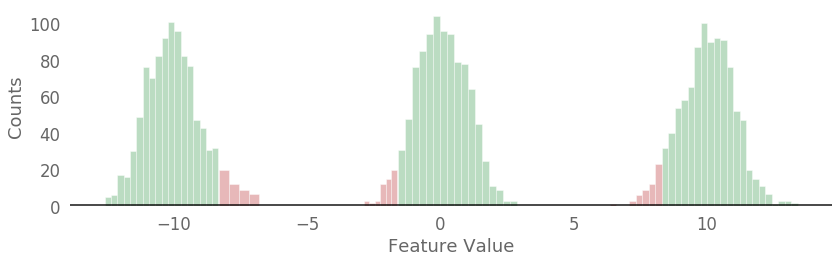

In [35]:
# Set graph style
sns.set(font_scale = 1.5)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               'grid.linestyle': '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4', 'axes.grid': False})

# Set figure size
f, ax = plt.subplots(figsize=(12, 4))

for ii in range(No_Critical_Features):
    # Get critical features
    X_temp = critical_features[ii]
    y_temp = y_critical_targets[ii]
    
    # Get indices for true cases
    X_true = [X_temp[jj] for jj in range(len(y_temp)) if y_temp[jj] == 1]
    X_false = [X_temp[jj] for jj in range(len(y_temp)) if y_temp[jj] == 0]
    
    # Plot true values
    sns.distplot(X_true, color = 'g',  kde=False, ax = ax)
    sns.distplot(X_false, color = 'r',  kde=False, ax = ax)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Set axis labels
plt.xlabel('Feature Value')
plt.ylabel('Counts')

 # Tight layout
plt.tight_layout()

plt.show()

# Save figure
# plt.savefig(f'Critical Feature Distribution.png', dpi = 1080)

In [0]:
# Define critical feature labels
critical_feature_labels =  [f'Critical {ii}' for ii in range(1, No_Critical_Features + 1)]

# Convert list to numpy arrays
X_critical = np.asarray(critical_features, dtype=np.float64).T
X_critical = pd.DataFrame(X_critical, columns = critical_feature_labels)

# Create feature matrix
X_all = pd.concat([X_madelon, X_critical], axis = 1)

# Create target
y_all = np.array([y_madelon[ii] * y_critical[ii] for ii in range(len(y_madelon))])

In [0]:
# Split the X_all and y_all
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, 
                                                                    test_size = 0.30,
                                                                    random_state = 42)

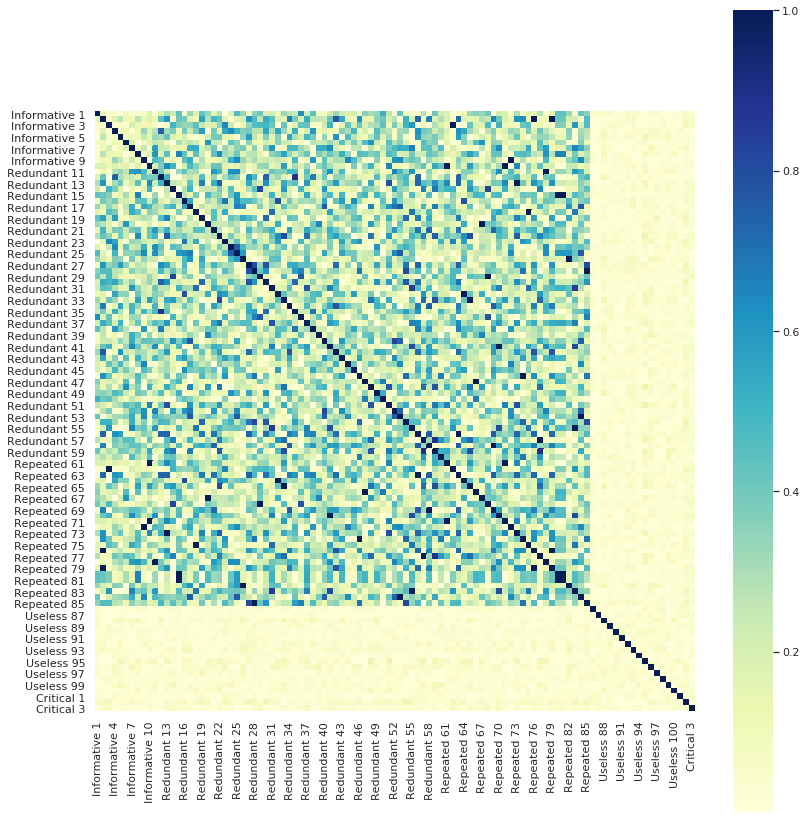

In [38]:
# Make correlation matrix
corr_matrix = X_all_train.corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(12, 12))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax)

# Tight layout
f.tight_layout()

plt.show()

# Save figure
# f.savefig('correlation_matrix.png', dpi = 1080)

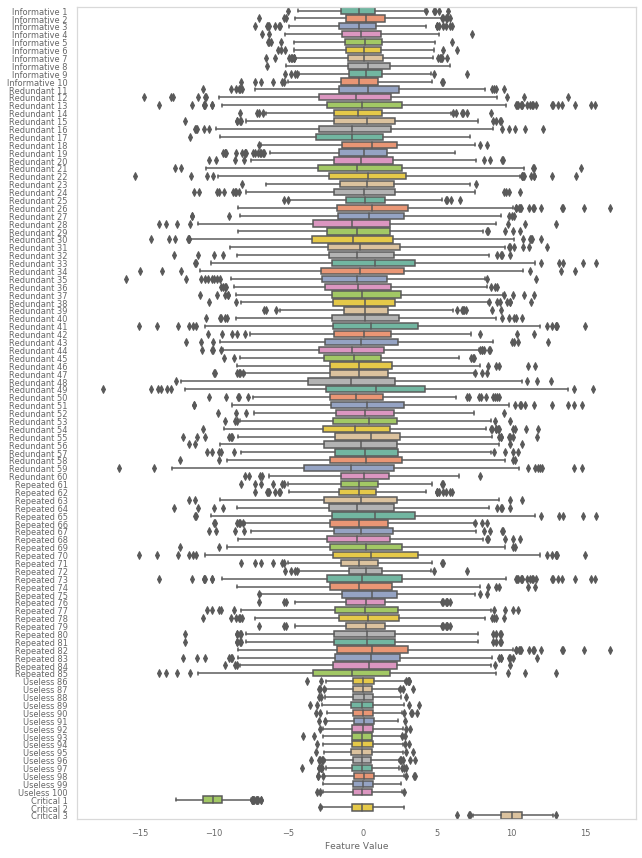

In [39]:
# Set graph style
sns.set(font_scale = 0.75)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               'grid.linestyle': '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4', 'axes.grid': False})

# Create box plots based on feature type

# Set the figure size
f, ax = plt.subplots(figsize=(9, 12))
sns.boxplot(data=X_all_train, orient="h", palette="Set2")

# Set axis label
plt.xlabel('Feature Value')

# Tight layout
f.tight_layout()

plt.show()

# Save figure
# f.savefig(f'Box Plots.png', dpi = 1080)

In [40]:
# Define steps
step1 = {'Constant Features': {'frac_constant_values': 0.95}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)

Removing Constant Features
[]

Done selecting features


In [41]:
# Define steps
step1 = {'Correlated Features': {'correlation_threshold': 0.95}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)

Removing Correlated Features
['Repeated 61', 'Repeated 62', 'Repeated 63', 'Repeated 64', 'Repeated 65', 'Repeated 66', 'Repeated 67', 'Repeated 68', 'Repeated 69', 'Repeated 70', 'Repeated 71', 'Repeated 72', 'Repeated 73', 'Repeated 74', 'Repeated 75', 'Repeated 76', 'Repeated 77', 'Repeated 78', 'Repeated 79', 'Repeated 80', 'Repeated 81', 'Repeated 82', 'Repeated 83', 'Repeated 84', 'Repeated 85']

Done selecting features


In [42]:
# Define estimator
estimator = RandomForestClassifier(n_estimators = 100, max_depth = 7, 
                                   min_samples_leaf = 2, min_samples_split = 2,
                                   n_jobs = -1)

# Define steps
step1 = {'Relevant Features': {'cv': 5,
                               'estimator': estimator,
                                'n_estimators': 1000,
                                'max_iter': 50,
                                'verbose': 0,
                                'random_state': 42}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)

Selecting relevant features
Progress: |██████████████████████████████████████████████████| 100.0% Complete
['Informative 1', 'Informative 3', 'Informative 4', 'Informative 7', 'Informative 9', 'Redundant 11', 'Redundant 12', 'Redundant 13', 'Redundant 15', 'Redundant 19', 'Redundant 21', 'Redundant 24', 'Redundant 25', 'Redundant 31', 'Redundant 36', 'Redundant 37', 'Redundant 39', 'Redundant 41', 'Redundant 42', 'Redundant 47', 'Redundant 50', 'Redundant 54', 'Redundant 55', 'Redundant 57', 'Redundant 59', 'Repeated 62', 'Repeated 66', 'Repeated 72', 'Repeated 73', 'Repeated 77', 'Repeated 78', 'Repeated 80', 'Repeated 81', 'Repeated 83', 'Critical 2', 'Critical 3']

Done selecting features


In [43]:
# Initiate classifier instance
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit classifier
estimator.fit(X_all_train, y_all_train)

# Make predictions
y_pred_train = estimator.predict(X_all_train)
y_pred_test = estimator.predict(X_all_test)

# Measure performance
accuracy_train = metrics.accuracy_score(y_all_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_all_test, y_pred_test)

# Message to user
print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')

The accuracy of the classifier on the train set was: 100.0
The accuracy of the classifier on the test set was: 80.66666666666666


In [44]:
# Initiate classifier instance
estimator = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = { 'n_estimators': [200],
                'class_weight': [None, 'balanced'],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [3, 4, 5, 6, 7, 8],
                'min_samples_split': [0.005, 0.01, 0.05, 0.10],
                'min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
                'criterion' :['gini', 'entropy']     ,
                'n_jobs': [-1]
             }

# Initialize GridSearch object
gscv = GridSearchCV(estimator, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = 'accuracy')

# Fit gscv
gscv.fit(X_all_train, y_all_train)

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
estimator.set_params(**best_params)

# Fit classifier
estimator.fit(X_all_train, y_all_train)

# Make predictions
y_pred_train = estimator.predict(X_all_train)
y_pred_test = estimator.predict(X_all_test)

# Measure performance
accuracy_train = metrics.accuracy_score(y_all_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_all_test, y_pred_test)

# Message to user
print(f'The accuracy of the classifier on the train set was: {accuracy_train*100}')
print(f'The accuracy of the classifier on the test set was: {accuracy_test*100}')

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 54.9min finished


The accuracy of the classifier on the train set was: 96.85714285714285
The accuracy of the classifier on the test set was: 81.0
